In [9]:
#Start up Spark (only needs to be done once)
%reset
import os
import pyspark.sql
import sys
#from pyspark.sql.functions import abs
#from pyspark.sql.functions import cosh
#from pyspark.sql.functions import cos
#from pyspark.sql.functions import sqrt

#!export KRB5CCNAME=FILE:/tmp/${USER}_krb
#!kinit -c /tmp/${USER}_krb

session = pyspark.sql.SparkSession.builder \
    .master(
        #"spark://10.64.22.66:7077"
        "local"
    ) \
    .appName(# Name of your application in the dashboard/UI
             "Zpeak"
            ) \
    .config(# Tell Spark to load some extra libraries from Maven (the Java repository)
            'spark.jars.packages',
            'org.diana-hep:spark-root_2.11:0.1.16,org.diana-hep:histogrammar-sparksql_2.11:1.0.4'
            )\
    .config('spark.cores.max,3'
            ) \
    .getOrCreate()
    
sc = session.sparkContext
sqlContext = session
#!hdfs dfs -ls hdfs://10.64.22.72:9000/NANO_Prod

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Loading NanoAod root files using spark-root package
Loading the nanoaod root file serving from hadoop cluster, and load the tree in dedicated TDirectory in the root file.

In [10]:
import json
from pyspark.sql.functions import lit
from samples import *


DFList = [] # will contain six dataframe from six processes with added xsec, eff, kfactor, weight, samples

for s in samples:
    print s
    dsPath = "hdfs://10.64.22.72:9000/"+BASE+samples[s]['filename']
    tempDF = sqlContext.read \
                .format("org.dianahep.sparkroot") \
                .option("tree", "Events") \
                .load(dsPath)\
                .withColumn("proc_xsec", lit(samples[s]['xsec']))\
                .withColumn("proc_eff", lit(samples[s]['eff']))\
                .withColumn("proc_kfactor", lit(samples[s]['kfactor']))\
                .withColumn("proc_weight", lit(samples[s]['weight']))\
                .withColumn("proc_sample", lit(s))        
    nev = tempDF.count()
    if samples[s]['xsec'] == None: # Data       
        DFList.append([tempDF.withColumn("proc_nevents",lit(nev))])        
    else: # MC
        samples[s]['weight'] = samples[s]['xsec'] * samples[s]['eff'] * samples[s]['kfactor'] * LUMI / nev
        DFList.append([tempDF.withColumn("proc_nevents",lit(nev))])        

print "Number of element:"
print "DFList size =", len(DFList)
print "Number of columns:"
print "DFList[0][0] =", len(DFList[0][0].columns)
print "DFList[0][0] =", len(DFList[1][0].columns)
print "DFList[1][0] =", len(DFList[2][0].columns)
print "DFList[2][0] =", len(DFList[3][0].columns)
print "DFList[3][0] =", len(DFList[4][0].columns)
print "DFList[4][0] =", len(DFList[5][0].columns)

TT
WW
SingleMuon
ZZ
DYJetsToLL
WZ
Number of element:
DFList size = 6
Number of columns:
DFList[0][0] = 979
DFList[0][0] = 964
DFList[1][0] = 869
DFList[2][0] = 964
DFList[3][0] = 979
DFList[4][0] = 964


# Reducing columns and Concatenate dataframes

Select related attributes and concatenate all dataframes under one for ease of interpretation.

In [11]:
header = list(DFList[0][0].columns) #infer the column header from one of the dataframe
globalAttr = [g for g in header if 'proc_' in g]
muonAttr = [muon for muon in header if 'Muon' in muon and 'genPart' not in muon]
jetAttr = [jet for jet in header if 'Jet' in jet and 'HLT' not in jet]
electronAttr = [electron for electron in header if 'Electron' in electron]
Attributes = muonAttr + globalAttr
DF = None
if DFList:
    DF = DFList[0][0].select(Attributes)
    for x in DFList[1:]:
        DF = DF.union(x[0].select(Attributes))
    print "Partitions:  %d" % DF.rdd.getNumPartitions()
    
DF.select('proc_sample','proc_weight','proc_xsec','proc_nevents').filter(DF.proc_sample.like("TT")).show(3)
DF.select('proc_sample','proc_weight','proc_xsec','proc_nevents').filter(DF.proc_sample.like("DYJetsToLL")).show(3)
DF.select('proc_sample','proc_weight','proc_xsec','proc_nevents').filter(DF.proc_sample.like("ZZ")).show(3)
DF.select('proc_sample','proc_weight','proc_xsec','proc_nevents').filter(DF.proc_sample.like("WZ")).show(3)
DF.select('proc_sample','proc_weight','proc_xsec','proc_nevents').filter(DF.proc_sample.like("WW")).show(3)
DF.select('proc_sample','proc_weight','proc_xsec','proc_nevents').filter(DF.proc_sample.like("SingleMuon")).show(3)

Partitions:  6
+-----------+-----------------+---------+------------+
|proc_sample|      proc_weight|proc_xsec|proc_nevents|
+-----------+-----------------+---------+------------+
|         TT|78.15226773660807|   831.76|      382077|
|         TT|78.15226773660807|   831.76|      382077|
|         TT|78.15226773660807|   831.76|      382077|
+-----------+-----------------+---------+------------+
only showing top 3 rows

+-----------+------------------+---------+------------+
|proc_sample|       proc_weight|proc_xsec|proc_nevents|
+-----------+------------------+---------+------------+
| DYJetsToLL|376.46712381090964|   5765.4|      549790|
| DYJetsToLL|376.46712381090964|   5765.4|      549790|
| DYJetsToLL|376.46712381090964|   5765.4|      549790|
+-----------+------------------+---------+------------+
only showing top 3 rows

+-----------+-----------------+---------+------------+
|proc_sample|      proc_weight|proc_xsec|proc_nevents|
+-----------+-----------------+---------+-------

# User Defined Function Definition and helper function

User Defined Function (UDF) is a function passes row by row to compute derived quantity such as invaraint mass of two physics objects involving multiple column. Helper function defined to facilitate event selection (using spark feature such as filter instead of python defined function (thanks to NANOAOD structure!))

In [12]:
#Define function
#MuonEta = df.withColumn('Muon_eta[0]',abs(df.Value))
from ROOT import TLorentzVector, gROOT

def invariantMass(arr):
    
    lepton1 = TLorentzVector(); lepton1.SetPtEtaPhiM(0.,0.,0.,0.)
    lepton2 = TLorentzVector(); lepton2.SetPtEtaPhiM(0.,0.,0.,0.)
    Zsystem = TLorentzVector(); Zsystem.SetPtEtaPhiM(0.,0.,0.,0.)
    
    lepton1.SetPtEtaPhiM(arr[0][0],arr[1][0],arr[2][0],arr[3][0])
    lepton2.SetPtEtaPhiM(arr[0][1],arr[1][1],arr[2][1],arr[3][1])
    Zsystem =lepton1+lepton2
    return float(Zsystem.M())

def passMuonSel(dataframe):
    return (dataframe.filter("Muon_pt[0]>10.0").filter("Muon_pfRelIso04_all[0]<0.12"))

def passEventSel(dataframe):
    return (dataframe.filter("nMuon>1").filter("Muon_pt[0]>25.0").filter("Muon_pfRelIso04_all[0]<0.5"))


# Event Selection

Physics object-oriented selection and general event selection. Note: eta selection is ommitted, the abs() feature is not permitted in spark filter. 

In [13]:
#muon selection
DF = passMuonSel(DF)
print "Muon Selection, number of event = ", DF.count()
DF = passEventSel(DF)
print "General Event Selection, number of event = ", DF.count()

Muon Selection, number of event =  607712
General Event Selection, number of event =  166244


# Computing the invaraince mass of two lepton 

Deploying the UDF to take kinemtaics variables of muons, constructing TLorenztVecotr on the fly and append a new column to reduced table (Muon object selection)

In [14]:
#header = list(df.columns)
#muonAttr = [muon for muon in header if 'Muon' in muon]
#dsMuons = df.select(muonAttr)

from pyspark.sql.functions import udf, array
from pyspark.sql.types import FloatType
MllUDF = udf(lambda z: invariantMass(z), FloatType())

DF = DF.withColumn('mll',MllUDF(array('Muon_pt','Muon_eta','Muon_phi','Muon_mass')))
#MLL = dfMuon.select(MllUDF(array('Muon_pt','Muon_eta','Muon_phi','Muon_mass')).alias('mll'))
#MLL.show(10)

DF.select('proc_sample','mll','proc_weight').filter(DF.proc_sample.like("TT")).show(5)
DF.select('proc_sample','mll','proc_weight').filter(DF.proc_sample.like("DYJetsToLL")).show(5)
DF.select('proc_sample','mll','proc_weight').filter(DF.proc_sample.like("ZZ")).show(5)
DF.select('proc_sample','mll','proc_weight').filter(DF.proc_sample.like("WZ")).show(5)
DF.select('proc_sample','mll','proc_weight').filter(DF.proc_sample.like("WW")).show(5)
DF.select('proc_sample','mll','proc_weight').filter(DF.proc_sample.like("SingleMuon")).show(5)

+-----------+---------+-----------------+
|proc_sample|      mll|      proc_weight|
+-----------+---------+-----------------+
|         TT|37.827938|78.15226773660807|
|         TT|51.837776|78.15226773660807|
|         TT|144.83916|78.15226773660807|
|         TT| 71.81045|78.15226773660807|
|         TT| 77.16723|78.15226773660807|
+-----------+---------+-----------------+
only showing top 5 rows

+-----------+----------+------------------+
|proc_sample|       mll|       proc_weight|
+-----------+----------+------------------+
| DYJetsToLL|  92.16055|376.46712381090964|
| DYJetsToLL|  78.37113|376.46712381090964|
| DYJetsToLL|  65.17627|376.46712381090964|
| DYJetsToLL|104.037766|376.46712381090964|
| DYJetsToLL| 90.211586|376.46712381090964|
+-----------+----------+------------------+
only showing top 5 rows

+-----------+---------+-----------------+
|proc_sample|      mll|      proc_weight|
+-----------+---------+-----------------+
|         ZZ| 70.18849|1.241169315871905|
|       

# Plotting the invariance mass of Z boson (matplotlib)

Via Histogrammer, the computed quantity which appended to the big table is plotted using external package such as matplotlib

In [12]:
#make histogram using matplotlib
from histogrammar import *
import histogrammar.sparksql
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

# set up binning.  get also bin centers, to use for data points
bin_size = 2
xmin = 50
xmax = 131 # should make this slightly larger than the desired end point of the plot
binning = np.arange(xmin,xmax,bin_size)
binning_centers = np.arange(xmin + bin_size/2.,xmax,bin_size)

# for MC, can plot all together as a stacked histogram
plt.hist([df['mll'] for df in DF.keys()],
         weights=[x['weight'] if x.proc_sample == samples[0] for x in DF],
         label=samples_dfs.keys(),
         color=color_dict.values(),
         bins=binning, histtype='bar', stacked=True
        )

#declaration of histogram
#histogrammar.sparksql.addMethods(dfMuon)
#hist = dfMuon.Bin(40, 0, 200, dfMuon['mll'])
#plt.xlabel('$M_{\mu\mu}$ [GeV]')
#plt.ylabel('Events')
#hist.plot.matplotlib(name="Invariant mass of Z boson")

plt.show()

SyntaxError: invalid syntax (<ipython-input-12-1210d1f6548f>, line 17)

# Plotting the invariance mass of Z boson (root)

Via histogrammer, the computed quantity which appended to the big table is plotted using numpy + root packages

In [9]:
#Using numpy + pyroot 
from histogrammar import *
import ROOT
import numpy as np

TTDF = np.array(DF.filter(DF.proc_sample.like("TT")).select('mll').select('weight').collect()).flatten()
DYDF = np.array(DF.filter(DF.proc_sample.like("DYJetsToLL")).select('mll').select('weight').collect()).flatten()
ZZDF = np.array(DF.filter(DF.proc_sample.like("ZZ")).select('mll').select('weight').collect()).flatten()
WZDF = np.array(DF.filter(DF.proc_sample.like("WZ")).select('mll').select('weight').collect()).flatten()
WWDF = np.array(DF.filter(DF.proc_sample.like("WW")).select('mll').select('weight').collect()).flatten()
DATADF = np.array(DF.filter(DF.proc_sample.like("SingleMuon")).select('mll').select('weight').collect()).flatten()
#Template
histogram = Bin(40, 0, 200, lambda x : x.weight )

histtt = histogram.copy()
histdy = histogram.copy()
histzz = histogram.copy()
histwz = histogram.copy()
histww = histogram.copy()
histdata = histogram.copy()

#histogram.fill.numpy(TTDF)

histtt.fill.numpy(TTDF)
histdy.fill.numpy(DYDF)
histzz.fill.numpy(ZZDF)
histwz.fill.numpy(WZDF)
histww.fill.numpy(WWDF)
histdata.fill.numpy(DATADF)

#stack = Stack.build(histtt,histdy,histzz,histwz,histww,histdata)
stack = Stack.build(histtt)
roothist = stack.plot.root("name", "Invaraince mass of dilepton")
for i, h in enumerate(roothist.values()):
    h.SetFillColor(i + 2)

c = ROOT.TCanvas("c1","The Canvas Title",800,600)
#roothist = histdy.plot.root("name", "Invaraince mass of dilepton")
roothist.GetYaxis().SetTitle("Events")
roothist.GetXaxis().SetTitle("M_{#mu#mu} [GeV]")
roothist.Draw()
c.Draw()
#c.SaveAs("test.png")


AnalysisException: u"cannot resolve '`mll`' given input columns: [proc_kfactor, Muon_pt, Jet_nMuons, proc_eff, proc_weight, Muon_miniPFRelIso_chg, Muon_pfRelIso03_chg, HLT_QuadMuon0_Dimuon0_Upsilon, Muon_nStations, nMuon, Muon_highPtId, Muon_sip3d, Muon_mass, Muon_sip3d_ugo, Muon_miniPFRelIso_all, Muon_jetIdx, Muon_isPFcand, Muon_charge, Muon_dxyErr, Muon_ip3d_ugo, Muon_dzErr, Muon_nTrackerLayers, HLT_QuadMuon0_Dimuon0_Jpsi, proc_sample, Muon_pfRelIso04_all, HLT_Dimuon0_Upsilon_Muon, Muon_tightCharge, Muon_eta, Muon_mvaTTH, Muon_ptErr, Muon_tightId, Muon_dxyErr_ugo, Muon_segmentComp, Muon_mediumId, Muon_cleanmask, Muon_dxy, proc_xsec, Muon_ip3d, Muon_softId, HLT_Dimuon0_Jpsi_Muon, Muon_phi, Muon_pfRelIso03_all, Muon_pdgId, Muon_dxy_ugo, Muon_dz];;\n'Project ['mll]\n+- Filter proc_sample#5857 LIKE TT\n   +- Filter (cast(Muon_pfRelIso04_all#174[0] as double) < cast(0.5 as double))\n      +- Filter (cast(Muon_pt#176[0] as double) > cast(25.0 as double))\n         +- Filter (nMuon#159 > 1)\n            +- Filter (cast(Muon_pfRelIso04_all#174[0] as double) < cast(0.12 as double))\n               +- Filter (cast(Muon_pt#176[0] as double) > cast(10.0 as double))\n                  +- Union\n                     :- Project [Jet_nMuons#136, nMuon#159, Muon_dxy#160, Muon_dxyErr#161, Muon_dxyErr_ugo#162, Muon_dxy_ugo#163, Muon_dz#164, Muon_dzErr#165, Muon_eta#166, Muon_ip3d#167, Muon_ip3d_ugo#168, Muon_mass#169, Muon_miniPFRelIso_all#170, Muon_miniPFRelIso_chg#171, Muon_pfRelIso03_all#172, Muon_pfRelIso03_chg#173, Muon_pfRelIso04_all#174, Muon_phi#175, Muon_pt#176, Muon_ptErr#177, Muon_segmentComp#178, Muon_sip3d#179, Muon_sip3d_ugo#180, Muon_mvaTTH#181, ... 21 more fields]\n                     :  +- Project [Jet_nMuons#136, nMuon#159, Muon_dxy#160, Muon_dxyErr#161, Muon_dxyErr_ugo#162, Muon_dxy_ugo#163, Muon_dz#164, Muon_dzErr#165, Muon_eta#166, Muon_ip3d#167, Muon_ip3d_ugo#168, Muon_mass#169, Muon_miniPFRelIso_all#170, Muon_miniPFRelIso_chg#171, Muon_pfRelIso03_all#172, Muon_pfRelIso03_chg#173, Muon_pfRelIso04_all#174, Muon_phi#175, Muon_pt#176, Muon_ptErr#177, Muon_segmentComp#178, Muon_sip3d#179, Muon_sip3d_ugo#180, Muon_mvaTTH#181, ... 21 more fields]\n                     :     +- Project [run#0, luminosityBlock#1, event#2L, CaloMET_phi#3, CaloMET_pt#4, CaloMET_sumEt#5, nElectron#6, Electron_deltaEtaSC#7, Electron_dr03EcalRecHitSumEt#8, Electron_dr03HcalDepth1TowerSumEt#9, Electron_dr03TkSumPt#10, Electron_dxy#11, Electron_dxyErr#12, Electron_dxyErr_ugo#13, Electron_dxy_ugo#14, Electron_dz#15, Electron_dzErr#16, Electron_eCorr#17, Electron_eInvMinusPInv#18, Electron_energyErr#19, Electron_eta#20, Electron_hoe#21, Electron_ip3d#22, Electron_ip3d_ugo#23, ... 955 more fields]\n                     :        +- Project [run#0, luminosityBlock#1, event#2L, CaloMET_phi#3, CaloMET_pt#4, CaloMET_sumEt#5, nElectron#6, Electron_deltaEtaSC#7, Electron_dr03EcalRecHitSumEt#8, Electron_dr03HcalDepth1TowerSumEt#9, Electron_dr03TkSumPt#10, Electron_dxy#11, Electron_dxyErr#12, Electron_dxyErr_ugo#13, Electron_dxy_ugo#14, Electron_dz#15, Electron_dzErr#16, Electron_eCorr#17, Electron_eInvMinusPInv#18, Electron_energyErr#19, Electron_eta#20, Electron_hoe#21, Electron_ip3d#22, Electron_ip3d_ugo#23, ... 954 more fields]\n                     :           +- Project [run#0, luminosityBlock#1, event#2L, CaloMET_phi#3, CaloMET_pt#4, CaloMET_sumEt#5, nElectron#6, Electron_deltaEtaSC#7, Electron_dr03EcalRecHitSumEt#8, Electron_dr03HcalDepth1TowerSumEt#9, Electron_dr03TkSumPt#10, Electron_dxy#11, Electron_dxyErr#12, Electron_dxyErr_ugo#13, Electron_dxy_ugo#14, Electron_dz#15, Electron_dzErr#16, Electron_eCorr#17, Electron_eInvMinusPInv#18, Electron_energyErr#19, Electron_eta#20, Electron_hoe#21, Electron_ip3d#22, Electron_ip3d_ugo#23, ... 953 more fields]\n                     :              +- Project [run#0, luminosityBlock#1, event#2L, CaloMET_phi#3, CaloMET_pt#4, CaloMET_sumEt#5, nElectron#6, Electron_deltaEtaSC#7, Electron_dr03EcalRecHitSumEt#8, Electron_dr03HcalDepth1TowerSumEt#9, Electron_dr03TkSumPt#10, Electron_dxy#11, Electron_dxyErr#12, Electron_dxyErr_ugo#13, Electron_dxy_ugo#14, Electron_dz#15, Electron_dzErr#16, Electron_eCorr#17, Electron_eInvMinusPInv#18, Electron_energyErr#19, Electron_eta#20, Electron_hoe#21, Electron_ip3d#22, Electron_ip3d_ugo#23, ... 952 more fields]\n                     :                 +- Project [run#0, luminosityBlock#1, event#2L, CaloMET_phi#3, CaloMET_pt#4, CaloMET_sumEt#5, nElectron#6, Electron_deltaEtaSC#7, Electron_dr03EcalRecHitSumEt#8, Electron_dr03HcalDepth1TowerSumEt#9, Electron_dr03TkSumPt#10, Electron_dxy#11, Electron_dxyErr#12, Electron_dxyErr_ugo#13, Electron_dxy_ugo#14, Electron_dz#15, Electron_dzErr#16, Electron_eCorr#17, Electron_eInvMinusPInv#18, Electron_energyErr#19, Electron_eta#20, Electron_hoe#21, Electron_ip3d#22, Electron_ip3d_ugo#23, ... 951 more fields]\n                     :                    +- Project [run#0, luminosityBlock#1, event#2L, CaloMET_phi#3, CaloMET_pt#4, CaloMET_sumEt#5, nElectron#6, Electron_deltaEtaSC#7, Electron_dr03EcalRecHitSumEt#8, Electron_dr03HcalDepth1TowerSumEt#9, Electron_dr03TkSumPt#10, Electron_dxy#11, Electron_dxyErr#12, Electron_dxyErr_ugo#13, Electron_dxy_ugo#14, Electron_dz#15, Electron_dzErr#16, Electron_eCorr#17, Electron_eInvMinusPInv#18, Electron_energyErr#19, Electron_eta#20, Electron_hoe#21, Electron_ip3d#22, Electron_ip3d_ugo#23, ... 950 more fields]\n                     :                       +- Relation[run#0,luminosityBlock#1,event#2L,CaloMET_phi#3,CaloMET_pt#4,CaloMET_sumEt#5,nElectron#6,Electron_deltaEtaSC#7,Electron_dr03EcalRecHitSumEt#8,Electron_dr03HcalDepth1TowerSumEt#9,Electron_dr03TkSumPt#10,Electron_dxy#11,Electron_dxyErr#12,Electron_dxyErr_ugo#13,Electron_dxy_ugo#14,Electron_dz#15,Electron_dzErr#16,Electron_eCorr#17,Electron_eInvMinusPInv#18,Electron_energyErr#19,Electron_eta#20,Electron_hoe#21,Electron_ip3d#22,Electron_ip3d_ugo#23,... 949 more fields] org.dianahep.sparkroot.package$RootTableScan@310cf2cd\n                     :- Project [Jet_nMuons#8934, nMuon#8947, Muon_dxy#8948, Muon_dxyErr#8949, Muon_dxyErr_ugo#8950, Muon_dxy_ugo#8951, Muon_dz#8952, Muon_dzErr#8953, Muon_eta#8954, Muon_ip3d#8955, Muon_ip3d_ugo#8956, Muon_mass#8957, Muon_miniPFRelIso_all#8958, Muon_miniPFRelIso_chg#8959, Muon_pfRelIso03_all#8960, Muon_pfRelIso03_chg#8961, Muon_pfRelIso04_all#8962, Muon_phi#8963, Muon_pt#8964, Muon_ptErr#8965, Muon_segmentComp#8966, Muon_sip3d#8967, Muon_sip3d_ugo#8968, Muon_mvaTTH#8969, ... 21 more fields]\n                     :  +- Project [Jet_nMuons#8934, nMuon#8947, Muon_dxy#8948, Muon_dxyErr#8949, Muon_dxyErr_ugo#8950, Muon_dxy_ugo#8951, Muon_dz#8952, Muon_dzErr#8953, Muon_eta#8954, Muon_ip3d#8955, Muon_ip3d_ugo#8956, Muon_mass#8957, Muon_miniPFRelIso_all#8958, Muon_miniPFRelIso_chg#8959, Muon_pfRelIso03_all#8960, Muon_pfRelIso03_chg#8961, Muon_pfRelIso04_all#8962, Muon_phi#8963, Muon_pt#8964, Muon_ptErr#8965, Muon_segmentComp#8966, Muon_sip3d#8967, Muon_sip3d_ugo#8968, Muon_mvaTTH#8969, ... 21 more fields]\n                     :     +- Project [run#8803, luminosityBlock#8804, event#8805L, CaloMET_phi#8806, CaloMET_pt#8807, CaloMET_sumEt#8808, nElectron#8809, Electron_deltaEtaSC#8810, Electron_dr03EcalRecHitSumEt#8811, Electron_dr03HcalDepth1TowerSumEt#8812, Electron_dr03TkSumPt#8813, Electron_dxy#8814, Electron_dxyErr#8815, Electron_dxyErr_ugo#8816, Electron_dxy_ugo#8817, Electron_dz#8818, Electron_dzErr#8819, Electron_eCorr#8820, Electron_eInvMinusPInv#8821, Electron_energyErr#8822, Electron_eta#8823, Electron_hoe#8824, Electron_ip3d#8825, Electron_ip3d_ugo#8826, ... 940 more fields]\n                     :        +- Project [run#8803, luminosityBlock#8804, event#8805L, CaloMET_phi#8806, CaloMET_pt#8807, CaloMET_sumEt#8808, nElectron#8809, Electron_deltaEtaSC#8810, Electron_dr03EcalRecHitSumEt#8811, Electron_dr03HcalDepth1TowerSumEt#8812, Electron_dr03TkSumPt#8813, Electron_dxy#8814, Electron_dxyErr#8815, Electron_dxyErr_ugo#8816, Electron_dxy_ugo#8817, Electron_dz#8818, Electron_dzErr#8819, Electron_eCorr#8820, Electron_eInvMinusPInv#8821, Electron_energyErr#8822, Electron_eta#8823, Electron_hoe#8824, Electron_ip3d#8825, Electron_ip3d_ugo#8826, ... 939 more fields]\n                     :           +- Project [run#8803, luminosityBlock#8804, event#8805L, CaloMET_phi#8806, CaloMET_pt#8807, CaloMET_sumEt#8808, nElectron#8809, Electron_deltaEtaSC#8810, Electron_dr03EcalRecHitSumEt#8811, Electron_dr03HcalDepth1TowerSumEt#8812, Electron_dr03TkSumPt#8813, Electron_dxy#8814, Electron_dxyErr#8815, Electron_dxyErr_ugo#8816, Electron_dxy_ugo#8817, Electron_dz#8818, Electron_dzErr#8819, Electron_eCorr#8820, Electron_eInvMinusPInv#8821, Electron_energyErr#8822, Electron_eta#8823, Electron_hoe#8824, Electron_ip3d#8825, Electron_ip3d_ugo#8826, ... 938 more fields]\n                     :              +- Project [run#8803, luminosityBlock#8804, event#8805L, CaloMET_phi#8806, CaloMET_pt#8807, CaloMET_sumEt#8808, nElectron#8809, Electron_deltaEtaSC#8810, Electron_dr03EcalRecHitSumEt#8811, Electron_dr03HcalDepth1TowerSumEt#8812, Electron_dr03TkSumPt#8813, Electron_dxy#8814, Electron_dxyErr#8815, Electron_dxyErr_ugo#8816, Electron_dxy_ugo#8817, Electron_dz#8818, Electron_dzErr#8819, Electron_eCorr#8820, Electron_eInvMinusPInv#8821, Electron_energyErr#8822, Electron_eta#8823, Electron_hoe#8824, Electron_ip3d#8825, Electron_ip3d_ugo#8826, ... 937 more fields]\n                     :                 +- Project [run#8803, luminosityBlock#8804, event#8805L, CaloMET_phi#8806, CaloMET_pt#8807, CaloMET_sumEt#8808, nElectron#8809, Electron_deltaEtaSC#8810, Electron_dr03EcalRecHitSumEt#8811, Electron_dr03HcalDepth1TowerSumEt#8812, Electron_dr03TkSumPt#8813, Electron_dxy#8814, Electron_dxyErr#8815, Electron_dxyErr_ugo#8816, Electron_dxy_ugo#8817, Electron_dz#8818, Electron_dzErr#8819, Electron_eCorr#8820, Electron_eInvMinusPInv#8821, Electron_energyErr#8822, Electron_eta#8823, Electron_hoe#8824, Electron_ip3d#8825, Electron_ip3d_ugo#8826, ... 936 more fields]\n                     :                    +- Project [run#8803, luminosityBlock#8804, event#8805L, CaloMET_phi#8806, CaloMET_pt#8807, CaloMET_sumEt#8808, nElectron#8809, Electron_deltaEtaSC#8810, Electron_dr03EcalRecHitSumEt#8811, Electron_dr03HcalDepth1TowerSumEt#8812, Electron_dr03TkSumPt#8813, Electron_dxy#8814, Electron_dxyErr#8815, Electron_dxyErr_ugo#8816, Electron_dxy_ugo#8817, Electron_dz#8818, Electron_dzErr#8819, Electron_eCorr#8820, Electron_eInvMinusPInv#8821, Electron_energyErr#8822, Electron_eta#8823, Electron_hoe#8824, Electron_ip3d#8825, Electron_ip3d_ugo#8826, ... 935 more fields]\n                     :                       +- Relation[run#8803,luminosityBlock#8804,event#8805L,CaloMET_phi#8806,CaloMET_pt#8807,CaloMET_sumEt#8808,nElectron#8809,Electron_deltaEtaSC#8810,Electron_dr03EcalRecHitSumEt#8811,Electron_dr03HcalDepth1TowerSumEt#8812,Electron_dr03TkSumPt#8813,Electron_dxy#8814,Electron_dxyErr#8815,Electron_dxyErr_ugo#8816,Electron_dxy_ugo#8817,Electron_dz#8818,Electron_dzErr#8819,Electron_eCorr#8820,Electron_eInvMinusPInv#8821,Electron_energyErr#8822,Electron_eta#8823,Electron_hoe#8824,Electron_ip3d#8825,Electron_ip3d_ugo#8826,... 934 more fields] org.dianahep.sparkroot.package$RootTableScan@687d8c39\n                     :- Project [Jet_nMuons#17567, nMuon#17578, Muon_dxy#17579, Muon_dxyErr#17580, Muon_dxyErr_ugo#17581, Muon_dxy_ugo#17582, Muon_dz#17583, Muon_dzErr#17584, Muon_eta#17585, Muon_ip3d#17586, Muon_ip3d_ugo#17587, Muon_mass#17588, Muon_miniPFRelIso_all#17589, Muon_miniPFRelIso_chg#17590, Muon_pfRelIso03_all#17591, Muon_pfRelIso03_chg#17592, Muon_pfRelIso04_all#17593, Muon_phi#17594, Muon_pt#17595, Muon_ptErr#17596, Muon_segmentComp#17597, Muon_sip3d#17598, Muon_sip3d_ugo#17599, Muon_mvaTTH#17600, ... 21 more fields]\n                     :  +- Project [Jet_nMuons#17567, nMuon#17578, Muon_dxy#17579, Muon_dxyErr#17580, Muon_dxyErr_ugo#17581, Muon_dxy_ugo#17582, Muon_dz#17583, Muon_dzErr#17584, Muon_eta#17585, Muon_ip3d#17586, Muon_ip3d_ugo#17587, Muon_mass#17588, Muon_miniPFRelIso_all#17589, Muon_miniPFRelIso_chg#17590, Muon_pfRelIso03_all#17591, Muon_pfRelIso03_chg#17592, Muon_pfRelIso04_all#17593, Muon_phi#17594, Muon_pt#17595, Muon_ptErr#17596, Muon_segmentComp#17597, Muon_sip3d#17598, Muon_sip3d_ugo#17599, Muon_mvaTTH#17600, ... 21 more fields]\n                     :     +- Project [run#17471, luminosityBlock#17472, event#17473L, CaloMET_phi#17474, CaloMET_pt#17475, CaloMET_sumEt#17476, nElectron#17477, Electron_deltaEtaSC#17478, Electron_dr03EcalRecHitSumEt#17479, Electron_dr03HcalDepth1TowerSumEt#17480, Electron_dr03TkSumPt#17481, Electron_dxy#17482, Electron_dxyErr#17483, Electron_dxyErr_ugo#17484, Electron_dxy_ugo#17485, Electron_dz#17486, Electron_dzErr#17487, Electron_eCorr#17488, Electron_eInvMinusPInv#17489, Electron_energyErr#17490, Electron_eta#17491, Electron_hoe#17492, Electron_ip3d#17493, Electron_ip3d_ugo#17494, ... 845 more fields]\n                     :        +- Project [run#17471, luminosityBlock#17472, event#17473L, CaloMET_phi#17474, CaloMET_pt#17475, CaloMET_sumEt#17476, nElectron#17477, Electron_deltaEtaSC#17478, Electron_dr03EcalRecHitSumEt#17479, Electron_dr03HcalDepth1TowerSumEt#17480, Electron_dr03TkSumPt#17481, Electron_dxy#17482, Electron_dxyErr#17483, Electron_dxyErr_ugo#17484, Electron_dxy_ugo#17485, Electron_dz#17486, Electron_dzErr#17487, Electron_eCorr#17488, Electron_eInvMinusPInv#17489, Electron_energyErr#17490, Electron_eta#17491, Electron_hoe#17492, Electron_ip3d#17493, Electron_ip3d_ugo#17494, ... 844 more fields]\n                     :           +- Project [run#17471, luminosityBlock#17472, event#17473L, CaloMET_phi#17474, CaloMET_pt#17475, CaloMET_sumEt#17476, nElectron#17477, Electron_deltaEtaSC#17478, Electron_dr03EcalRecHitSumEt#17479, Electron_dr03HcalDepth1TowerSumEt#17480, Electron_dr03TkSumPt#17481, Electron_dxy#17482, Electron_dxyErr#17483, Electron_dxyErr_ugo#17484, Electron_dxy_ugo#17485, Electron_dz#17486, Electron_dzErr#17487, Electron_eCorr#17488, Electron_eInvMinusPInv#17489, Electron_energyErr#17490, Electron_eta#17491, Electron_hoe#17492, Electron_ip3d#17493, Electron_ip3d_ugo#17494, ... 843 more fields]\n                     :              +- Project [run#17471, luminosityBlock#17472, event#17473L, CaloMET_phi#17474, CaloMET_pt#17475, CaloMET_sumEt#17476, nElectron#17477, Electron_deltaEtaSC#17478, Electron_dr03EcalRecHitSumEt#17479, Electron_dr03HcalDepth1TowerSumEt#17480, Electron_dr03TkSumPt#17481, Electron_dxy#17482, Electron_dxyErr#17483, Electron_dxyErr_ugo#17484, Electron_dxy_ugo#17485, Electron_dz#17486, Electron_dzErr#17487, Electron_eCorr#17488, Electron_eInvMinusPInv#17489, Electron_energyErr#17490, Electron_eta#17491, Electron_hoe#17492, Electron_ip3d#17493, Electron_ip3d_ugo#17494, ... 842 more fields]\n                     :                 +- Project [run#17471, luminosityBlock#17472, event#17473L, CaloMET_phi#17474, CaloMET_pt#17475, CaloMET_sumEt#17476, nElectron#17477, Electron_deltaEtaSC#17478, Electron_dr03EcalRecHitSumEt#17479, Electron_dr03HcalDepth1TowerSumEt#17480, Electron_dr03TkSumPt#17481, Electron_dxy#17482, Electron_dxyErr#17483, Electron_dxyErr_ugo#17484, Electron_dxy_ugo#17485, Electron_dz#17486, Electron_dzErr#17487, Electron_eCorr#17488, Electron_eInvMinusPInv#17489, Electron_energyErr#17490, Electron_eta#17491, Electron_hoe#17492, Electron_ip3d#17493, Electron_ip3d_ugo#17494, ... 841 more fields]\n                     :                    +- Project [run#17471, luminosityBlock#17472, event#17473L, CaloMET_phi#17474, CaloMET_pt#17475, CaloMET_sumEt#17476, nElectron#17477, Electron_deltaEtaSC#17478, Electron_dr03EcalRecHitSumEt#17479, Electron_dr03HcalDepth1TowerSumEt#17480, Electron_dr03TkSumPt#17481, Electron_dxy#17482, Electron_dxyErr#17483, Electron_dxyErr_ugo#17484, Electron_dxy_ugo#17485, Electron_dz#17486, Electron_dzErr#17487, Electron_eCorr#17488, Electron_eInvMinusPInv#17489, Electron_energyErr#17490, Electron_eta#17491, Electron_hoe#17492, Electron_ip3d#17493, Electron_ip3d_ugo#17494, ... 840 more fields]\n                     :                       +- Relation[run#17471,luminosityBlock#17472,event#17473L,CaloMET_phi#17474,CaloMET_pt#17475,CaloMET_sumEt#17476,nElectron#17477,Electron_deltaEtaSC#17478,Electron_dr03EcalRecHitSumEt#17479,Electron_dr03HcalDepth1TowerSumEt#17480,Electron_dr03TkSumPt#17481,Electron_dxy#17482,Electron_dxyErr#17483,Electron_dxyErr_ugo#17484,Electron_dxy_ugo#17485,Electron_dz#17486,Electron_dzErr#17487,Electron_eCorr#17488,Electron_eInvMinusPInv#17489,Electron_energyErr#17490,Electron_eta#17491,Electron_hoe#17492,Electron_ip3d#17493,Electron_ip3d_ugo#17494,... 839 more fields] org.dianahep.sparkroot.package$RootTableScan@75142002\n                     :- Project [Jet_nMuons#25415, nMuon#25428, Muon_dxy#25429, Muon_dxyErr#25430, Muon_dxyErr_ugo#25431, Muon_dxy_ugo#25432, Muon_dz#25433, Muon_dzErr#25434, Muon_eta#25435, Muon_ip3d#25436, Muon_ip3d_ugo#25437, Muon_mass#25438, Muon_miniPFRelIso_all#25439, Muon_miniPFRelIso_chg#25440, Muon_pfRelIso03_all#25441, Muon_pfRelIso03_chg#25442, Muon_pfRelIso04_all#25443, Muon_phi#25444, Muon_pt#25445, Muon_ptErr#25446, Muon_segmentComp#25447, Muon_sip3d#25448, Muon_sip3d_ugo#25449, Muon_mvaTTH#25450, ... 21 more fields]\n                     :  +- Project [run#25284, luminosityBlock#25285, event#25286L, CaloMET_phi#25287, CaloMET_pt#25288, CaloMET_sumEt#25289, nElectron#25290, Electron_deltaEtaSC#25291, Electron_dr03EcalRecHitSumEt#25292, Electron_dr03HcalDepth1TowerSumEt#25293, Electron_dr03TkSumPt#25294, Electron_dxy#25295, Electron_dxyErr#25296, Electron_dxyErr_ugo#25297, Electron_dxy_ugo#25298, Electron_dz#25299, Electron_dzErr#25300, Electron_eCorr#25301, Electron_eInvMinusPInv#25302, Electron_energyErr#25303, Electron_eta#25304, Electron_hoe#25305, Electron_ip3d#25306, Electron_ip3d_ugo#25307, ... 940 more fields]\n                     :     +- Project [run#25284, luminosityBlock#25285, event#25286L, CaloMET_phi#25287, CaloMET_pt#25288, CaloMET_sumEt#25289, nElectron#25290, Electron_deltaEtaSC#25291, Electron_dr03EcalRecHitSumEt#25292, Electron_dr03HcalDepth1TowerSumEt#25293, Electron_dr03TkSumPt#25294, Electron_dxy#25295, Electron_dxyErr#25296, Electron_dxyErr_ugo#25297, Electron_dxy_ugo#25298, Electron_dz#25299, Electron_dzErr#25300, Electron_eCorr#25301, Electron_eInvMinusPInv#25302, Electron_energyErr#25303, Electron_eta#25304, Electron_hoe#25305, Electron_ip3d#25306, Electron_ip3d_ugo#25307, ... 939 more fields]\n                     :        +- Project [run#25284, luminosityBlock#25285, event#25286L, CaloMET_phi#25287, CaloMET_pt#25288, CaloMET_sumEt#25289, nElectron#25290, Electron_deltaEtaSC#25291, Electron_dr03EcalRecHitSumEt#25292, Electron_dr03HcalDepth1TowerSumEt#25293, Electron_dr03TkSumPt#25294, Electron_dxy#25295, Electron_dxyErr#25296, Electron_dxyErr_ugo#25297, Electron_dxy_ugo#25298, Electron_dz#25299, Electron_dzErr#25300, Electron_eCorr#25301, Electron_eInvMinusPInv#25302, Electron_energyErr#25303, Electron_eta#25304, Electron_hoe#25305, Electron_ip3d#25306, Electron_ip3d_ugo#25307, ... 938 more fields]\n                     :           +- Project [run#25284, luminosityBlock#25285, event#25286L, CaloMET_phi#25287, CaloMET_pt#25288, CaloMET_sumEt#25289, nElectron#25290, Electron_deltaEtaSC#25291, Electron_dr03EcalRecHitSumEt#25292, Electron_dr03HcalDepth1TowerSumEt#25293, Electron_dr03TkSumPt#25294, Electron_dxy#25295, Electron_dxyErr#25296, Electron_dxyErr_ugo#25297, Electron_dxy_ugo#25298, Electron_dz#25299, Electron_dzErr#25300, Electron_eCorr#25301, Electron_eInvMinusPInv#25302, Electron_energyErr#25303, Electron_eta#25304, Electron_hoe#25305, Electron_ip3d#25306, Electron_ip3d_ugo#25307, ... 937 more fields]\n                     :              +- Project [run#25284, luminosityBlock#25285, event#25286L, CaloMET_phi#25287, CaloMET_pt#25288, CaloMET_sumEt#25289, nElectron#25290, Electron_deltaEtaSC#25291, Electron_dr03EcalRecHitSumEt#25292, Electron_dr03HcalDepth1TowerSumEt#25293, Electron_dr03TkSumPt#25294, Electron_dxy#25295, Electron_dxyErr#25296, Electron_dxyErr_ugo#25297, Electron_dxy_ugo#25298, Electron_dz#25299, Electron_dzErr#25300, Electron_eCorr#25301, Electron_eInvMinusPInv#25302, Electron_energyErr#25303, Electron_eta#25304, Electron_hoe#25305, Electron_ip3d#25306, Electron_ip3d_ugo#25307, ... 936 more fields]\n                     :                 +- Project [run#25284, luminosityBlock#25285, event#25286L, CaloMET_phi#25287, CaloMET_pt#25288, CaloMET_sumEt#25289, nElectron#25290, Electron_deltaEtaSC#25291, Electron_dr03EcalRecHitSumEt#25292, Electron_dr03HcalDepth1TowerSumEt#25293, Electron_dr03TkSumPt#25294, Electron_dxy#25295, Electron_dxyErr#25296, Electron_dxyErr_ugo#25297, Electron_dxy_ugo#25298, Electron_dz#25299, Electron_dzErr#25300, Electron_eCorr#25301, Electron_eInvMinusPInv#25302, Electron_energyErr#25303, Electron_eta#25304, Electron_hoe#25305, Electron_ip3d#25306, Electron_ip3d_ugo#25307, ... 935 more fields]\n                     :                    +- Relation[run#25284,luminosityBlock#25285,event#25286L,CaloMET_phi#25287,CaloMET_pt#25288,CaloMET_sumEt#25289,nElectron#25290,Electron_deltaEtaSC#25291,Electron_dr03EcalRecHitSumEt#25292,Electron_dr03HcalDepth1TowerSumEt#25293,Electron_dr03TkSumPt#25294,Electron_dxy#25295,Electron_dxyErr#25296,Electron_dxyErr_ugo#25297,Electron_dxy_ugo#25298,Electron_dz#25299,Electron_dzErr#25300,Electron_eCorr#25301,Electron_eInvMinusPInv#25302,Electron_energyErr#25303,Electron_eta#25304,Electron_hoe#25305,Electron_ip3d#25306,Electron_ip3d_ugo#25307,... 934 more fields] org.dianahep.sparkroot.package$RootTableScan@6cea9ffc\n                     :- Project [Jet_nMuons#34088, nMuon#34111, Muon_dxy#34112, Muon_dxyErr#34113, Muon_dxyErr_ugo#34114, Muon_dxy_ugo#34115, Muon_dz#34116, Muon_dzErr#34117, Muon_eta#34118, Muon_ip3d#34119, Muon_ip3d_ugo#34120, Muon_mass#34121, Muon_miniPFRelIso_all#34122, Muon_miniPFRelIso_chg#34123, Muon_pfRelIso03_all#34124, Muon_pfRelIso03_chg#34125, Muon_pfRelIso04_all#34126, Muon_phi#34127, Muon_pt#34128, Muon_ptErr#34129, Muon_segmentComp#34130, Muon_sip3d#34131, Muon_sip3d_ugo#34132, Muon_mvaTTH#34133, ... 21 more fields]\n                     :  +- Project [run#33952, luminosityBlock#33953, event#33954L, CaloMET_phi#33955, CaloMET_pt#33956, CaloMET_sumEt#33957, nElectron#33958, Electron_deltaEtaSC#33959, Electron_dr03EcalRecHitSumEt#33960, Electron_dr03HcalDepth1TowerSumEt#33961, Electron_dr03TkSumPt#33962, Electron_dxy#33963, Electron_dxyErr#33964, Electron_dxyErr_ugo#33965, Electron_dxy_ugo#33966, Electron_dz#33967, Electron_dzErr#33968, Electron_eCorr#33969, Electron_eInvMinusPInv#33970, Electron_energyErr#33971, Electron_eta#33972, Electron_hoe#33973, Electron_ip3d#33974, Electron_ip3d_ugo#33975, ... 955 more fields]\n                     :     +- Project [run#33952, luminosityBlock#33953, event#33954L, CaloMET_phi#33955, CaloMET_pt#33956, CaloMET_sumEt#33957, nElectron#33958, Electron_deltaEtaSC#33959, Electron_dr03EcalRecHitSumEt#33960, Electron_dr03HcalDepth1TowerSumEt#33961, Electron_dr03TkSumPt#33962, Electron_dxy#33963, Electron_dxyErr#33964, Electron_dxyErr_ugo#33965, Electron_dxy_ugo#33966, Electron_dz#33967, Electron_dzErr#33968, Electron_eCorr#33969, Electron_eInvMinusPInv#33970, Electron_energyErr#33971, Electron_eta#33972, Electron_hoe#33973, Electron_ip3d#33974, Electron_ip3d_ugo#33975, ... 954 more fields]\n                     :        +- Project [run#33952, luminosityBlock#33953, event#33954L, CaloMET_phi#33955, CaloMET_pt#33956, CaloMET_sumEt#33957, nElectron#33958, Electron_deltaEtaSC#33959, Electron_dr03EcalRecHitSumEt#33960, Electron_dr03HcalDepth1TowerSumEt#33961, Electron_dr03TkSumPt#33962, Electron_dxy#33963, Electron_dxyErr#33964, Electron_dxyErr_ugo#33965, Electron_dxy_ugo#33966, Electron_dz#33967, Electron_dzErr#33968, Electron_eCorr#33969, Electron_eInvMinusPInv#33970, Electron_energyErr#33971, Electron_eta#33972, Electron_hoe#33973, Electron_ip3d#33974, Electron_ip3d_ugo#33975, ... 953 more fields]\n                     :           +- Project [run#33952, luminosityBlock#33953, event#33954L, CaloMET_phi#33955, CaloMET_pt#33956, CaloMET_sumEt#33957, nElectron#33958, Electron_deltaEtaSC#33959, Electron_dr03EcalRecHitSumEt#33960, Electron_dr03HcalDepth1TowerSumEt#33961, Electron_dr03TkSumPt#33962, Electron_dxy#33963, Electron_dxyErr#33964, Electron_dxyErr_ugo#33965, Electron_dxy_ugo#33966, Electron_dz#33967, Electron_dzErr#33968, Electron_eCorr#33969, Electron_eInvMinusPInv#33970, Electron_energyErr#33971, Electron_eta#33972, Electron_hoe#33973, Electron_ip3d#33974, Electron_ip3d_ugo#33975, ... 952 more fields]\n                     :              +- Project [run#33952, luminosityBlock#33953, event#33954L, CaloMET_phi#33955, CaloMET_pt#33956, CaloMET_sumEt#33957, nElectron#33958, Electron_deltaEtaSC#33959, Electron_dr03EcalRecHitSumEt#33960, Electron_dr03HcalDepth1TowerSumEt#33961, Electron_dr03TkSumPt#33962, Electron_dxy#33963, Electron_dxyErr#33964, Electron_dxyErr_ugo#33965, Electron_dxy_ugo#33966, Electron_dz#33967, Electron_dzErr#33968, Electron_eCorr#33969, Electron_eInvMinusPInv#33970, Electron_energyErr#33971, Electron_eta#33972, Electron_hoe#33973, Electron_ip3d#33974, Electron_ip3d_ugo#33975, ... 951 more fields]\n                     :                 +- Project [run#33952, luminosityBlock#33953, event#33954L, CaloMET_phi#33955, CaloMET_pt#33956, CaloMET_sumEt#33957, nElectron#33958, Electron_deltaEtaSC#33959, Electron_dr03EcalRecHitSumEt#33960, Electron_dr03HcalDepth1TowerSumEt#33961, Electron_dr03TkSumPt#33962, Electron_dxy#33963, Electron_dxyErr#33964, Electron_dxyErr_ugo#33965, Electron_dxy_ugo#33966, Electron_dz#33967, Electron_dzErr#33968, Electron_eCorr#33969, Electron_eInvMinusPInv#33970, Electron_energyErr#33971, Electron_eta#33972, Electron_hoe#33973, Electron_ip3d#33974, Electron_ip3d_ugo#33975, ... 950 more fields]\n                     :                    +- Relation[run#33952,luminosityBlock#33953,event#33954L,CaloMET_phi#33955,CaloMET_pt#33956,CaloMET_sumEt#33957,nElectron#33958,Electron_deltaEtaSC#33959,Electron_dr03EcalRecHitSumEt#33960,Electron_dr03HcalDepth1TowerSumEt#33961,Electron_dr03TkSumPt#33962,Electron_dxy#33963,Electron_dxyErr#33964,Electron_dxyErr_ugo#33965,Electron_dxy_ugo#33966,Electron_dz#33967,Electron_dzErr#33968,Electron_eCorr#33969,Electron_eInvMinusPInv#33970,Electron_energyErr#33971,Electron_eta#33972,Electron_hoe#33973,Electron_ip3d#33974,Electron_ip3d_ugo#33975,... 949 more fields] org.dianahep.sparkroot.package$RootTableScan@5e51d594\n                     +- Project [Jet_nMuons#42886, nMuon#42899, Muon_dxy#42900, Muon_dxyErr#42901, Muon_dxyErr_ugo#42902, Muon_dxy_ugo#42903, Muon_dz#42904, Muon_dzErr#42905, Muon_eta#42906, Muon_ip3d#42907, Muon_ip3d_ugo#42908, Muon_mass#42909, Muon_miniPFRelIso_all#42910, Muon_miniPFRelIso_chg#42911, Muon_pfRelIso03_all#42912, Muon_pfRelIso03_chg#42913, Muon_pfRelIso04_all#42914, Muon_phi#42915, Muon_pt#42916, Muon_ptErr#42917, Muon_segmentComp#42918, Muon_sip3d#42919, Muon_sip3d_ugo#42920, Muon_mvaTTH#42921, ... 21 more fields]\n                        +- Project [run#42755, luminosityBlock#42756, event#42757L, CaloMET_phi#42758, CaloMET_pt#42759, CaloMET_sumEt#42760, nElectron#42761, Electron_deltaEtaSC#42762, Electron_dr03EcalRecHitSumEt#42763, Electron_dr03HcalDepth1TowerSumEt#42764, Electron_dr03TkSumPt#42765, Electron_dxy#42766, Electron_dxyErr#42767, Electron_dxyErr_ugo#42768, Electron_dxy_ugo#42769, Electron_dz#42770, Electron_dzErr#42771, Electron_eCorr#42772, Electron_eInvMinusPInv#42773, Electron_energyErr#42774, Electron_eta#42775, Electron_hoe#42776, Electron_ip3d#42777, Electron_ip3d_ugo#42778, ... 940 more fields]\n                           +- Project [run#42755, luminosityBlock#42756, event#42757L, CaloMET_phi#42758, CaloMET_pt#42759, CaloMET_sumEt#42760, nElectron#42761, Electron_deltaEtaSC#42762, Electron_dr03EcalRecHitSumEt#42763, Electron_dr03HcalDepth1TowerSumEt#42764, Electron_dr03TkSumPt#42765, Electron_dxy#42766, Electron_dxyErr#42767, Electron_dxyErr_ugo#42768, Electron_dxy_ugo#42769, Electron_dz#42770, Electron_dzErr#42771, Electron_eCorr#42772, Electron_eInvMinusPInv#42773, Electron_energyErr#42774, Electron_eta#42775, Electron_hoe#42776, Electron_ip3d#42777, Electron_ip3d_ugo#42778, ... 939 more fields]\n                              +- Project [run#42755, luminosityBlock#42756, event#42757L, CaloMET_phi#42758, CaloMET_pt#42759, CaloMET_sumEt#42760, nElectron#42761, Electron_deltaEtaSC#42762, Electron_dr03EcalRecHitSumEt#42763, Electron_dr03HcalDepth1TowerSumEt#42764, Electron_dr03TkSumPt#42765, Electron_dxy#42766, Electron_dxyErr#42767, Electron_dxyErr_ugo#42768, Electron_dxy_ugo#42769, Electron_dz#42770, Electron_dzErr#42771, Electron_eCorr#42772, Electron_eInvMinusPInv#42773, Electron_energyErr#42774, Electron_eta#42775, Electron_hoe#42776, Electron_ip3d#42777, Electron_ip3d_ugo#42778, ... 938 more fields]\n                                 +- Project [run#42755, luminosityBlock#42756, event#42757L, CaloMET_phi#42758, CaloMET_pt#42759, CaloMET_sumEt#42760, nElectron#42761, Electron_deltaEtaSC#42762, Electron_dr03EcalRecHitSumEt#42763, Electron_dr03HcalDepth1TowerSumEt#42764, Electron_dr03TkSumPt#42765, Electron_dxy#42766, Electron_dxyErr#42767, Electron_dxyErr_ugo#42768, Electron_dxy_ugo#42769, Electron_dz#42770, Electron_dzErr#42771, Electron_eCorr#42772, Electron_eInvMinusPInv#42773, Electron_energyErr#42774, Electron_eta#42775, Electron_hoe#42776, Electron_ip3d#42777, Electron_ip3d_ugo#42778, ... 937 more fields]\n                                    +- Project [run#42755, luminosityBlock#42756, event#42757L, CaloMET_phi#42758, CaloMET_pt#42759, CaloMET_sumEt#42760, nElectron#42761, Electron_deltaEtaSC#42762, Electron_dr03EcalRecHitSumEt#42763, Electron_dr03HcalDepth1TowerSumEt#42764, Electron_dr03TkSumPt#42765, Electron_dxy#42766, Electron_dxyErr#42767, Electron_dxyErr_ugo#42768, Electron_dxy_ugo#42769, Electron_dz#42770, Electron_dzErr#42771, Electron_eCorr#42772, Electron_eInvMinusPInv#42773, Electron_energyErr#42774, Electron_eta#42775, Electron_hoe#42776, Electron_ip3d#42777, Electron_ip3d_ugo#42778, ... 936 more fields]\n                                       +- Project [run#42755, luminosityBlock#42756, event#42757L, CaloMET_phi#42758, CaloMET_pt#42759, CaloMET_sumEt#42760, nElectron#42761, Electron_deltaEtaSC#42762, Electron_dr03EcalRecHitSumEt#42763, Electron_dr03HcalDepth1TowerSumEt#42764, Electron_dr03TkSumPt#42765, Electron_dxy#42766, Electron_dxyErr#42767, Electron_dxyErr_ugo#42768, Electron_dxy_ugo#42769, Electron_dz#42770, Electron_dzErr#42771, Electron_eCorr#42772, Electron_eInvMinusPInv#42773, Electron_energyErr#42774, Electron_eta#42775, Electron_hoe#42776, Electron_ip3d#42777, Electron_ip3d_ugo#42778, ... 935 more fields]\n                                          +- Relation[run#42755,luminosityBlock#42756,event#42757L,CaloMET_phi#42758,CaloMET_pt#42759,CaloMET_sumEt#42760,nElectron#42761,Electron_deltaEtaSC#42762,Electron_dr03EcalRecHitSumEt#42763,Electron_dr03HcalDepth1TowerSumEt#42764,Electron_dr03TkSumPt#42765,Electron_dxy#42766,Electron_dxyErr#42767,Electron_dxyErr_ugo#42768,Electron_dxy_ugo#42769,Electron_dz#42770,Electron_dzErr#42771,Electron_eCorr#42772,Electron_eInvMinusPInv#42773,Electron_energyErr#42774,Electron_eta#42775,Electron_hoe#42776,Electron_ip3d#42777,Electron_ip3d_ugo#42778,... 934 more fields] org.dianahep.sparkroot.package$RootTableScan@69f232b9\n"

+--------+------------------+
|     mll|       proc_weight|
+--------+------------------+
|92.16055|376.46712381090964|
|78.37113|376.46712381090964|
|65.17627|376.46712381090964|
+--------+------------------+
only showing top 3 rows



Warning in <TROOT::Append>: Replacing existing TH1: name (Potential memory leak).


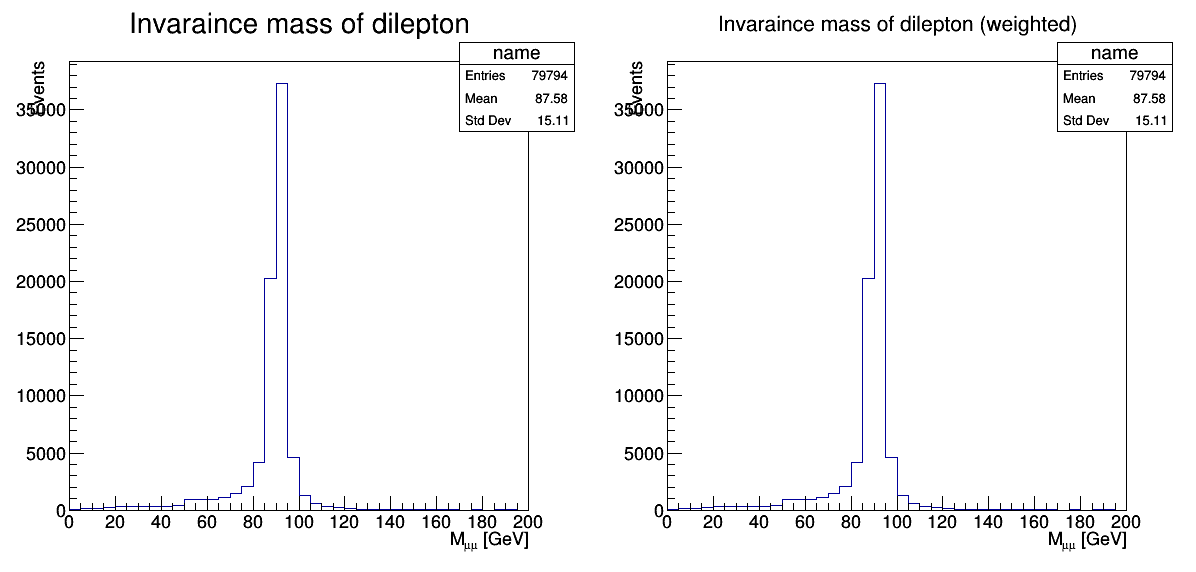

In [17]:
#Using numpy + pyroot 
from histogrammar import *
import histogrammar.sparksql
import histogrammar as hg
import ROOT
import numpy as np

df = DF.select('mll','proc_weight').filter(DF.proc_sample.like("DYJetsToLL"))
df.show(3)
histogrammar.sparksql.addMethods(df)
hist = df.Bin(40, 0, 200, df['mll'])
hist1 = df.Bin(40, 0, 200, df['mll'], hg.Count.ing(df['proc_weight']) )

c = ROOT.TCanvas("c1","The Canvas Title",1200,600)
c.Clear()
c.Divide(2,1)
c.cd(1)
#c.SetLogy()
roothist = hist.plot.root("name", "Invaraince mass of dilepton")
roothist.GetYaxis().SetTitle("Events")
roothist.GetXaxis().SetTitle("M_{#mu#mu} [GeV]")
roothist.Draw()

c.cd(2)
#c.SetLogy()
roothist1 = hist1.plot.root("name", "Invaraince mass of dilepton (weighted)")
roothist1.GetYaxis().SetTitle("Events")
roothist1.GetXaxis().SetTitle("M_{#mu#mu} [GeV]")
roothist1.Draw()
c.Draw()
